/sdf/data/lcls/ds/mfx/mfx101080524/results/lbgee/XSpecT/XSpect/XSpect_Controller.py:124: UserWarning: If you plan on using delayed key loading for the epix then please define key_epix and friendly_name_epix. And do not load it here for risk of OOM
  warnings.warn('If you plan on using delayed key loading for the epix then please define key_epix and friendly_name_epix. And do not load it here for risk of OOM')


Obtained shot properties
HDF5 import of keys completed. Time: 5.73 seconds
Mask: xray has been filtered on ipm by minimum threshold: 100.000
Shots removed: 623
Mask: simultaneous has been filtered on ipm by minimum threshold: 100.000
Shots removed: 532
Key: epix has been adu filtered by threshold: 3.000000
Shots combined for detector epix on filters: simultaneous and laser into epix_simultaneous_laser
Shots (3655) separated for detector epix on filters: xray and laser into epix_xray_laser
Shots combined for detector ipm on filters: simultaneous and laser into ipm_simultaneous_laser
Shots (3655) separated for detector ipm on filters: xray and laser into ipm_xray_laser
Shots combined for detector scan on filters: simultaneous and laser into scan_simultaneous_laser
Shots (3655) separated for detector scan on filters: xray and laser into scan_xray_laser
Shots combined for detector scanvar_indices on filters: simultaneous and laser into scanvar_indices_simultaneous_laser
Shots (3655) separa

/lscratch/lbgee/tmp/ipykernel_1630309/3602294936.py:29: RuntimeWarning: invalid value encountered in divide
  normed_laser_on_full = laser_on / norm_on[:, np.newaxis, np.newaxis]
/lscratch/lbgee/tmp/ipykernel_1630309/3602294936.py:30: RuntimeWarning: invalid value encountered in divide
  normed_laser_off_full = laser_off / norm_off[:, np.newaxis, np.newaxis]


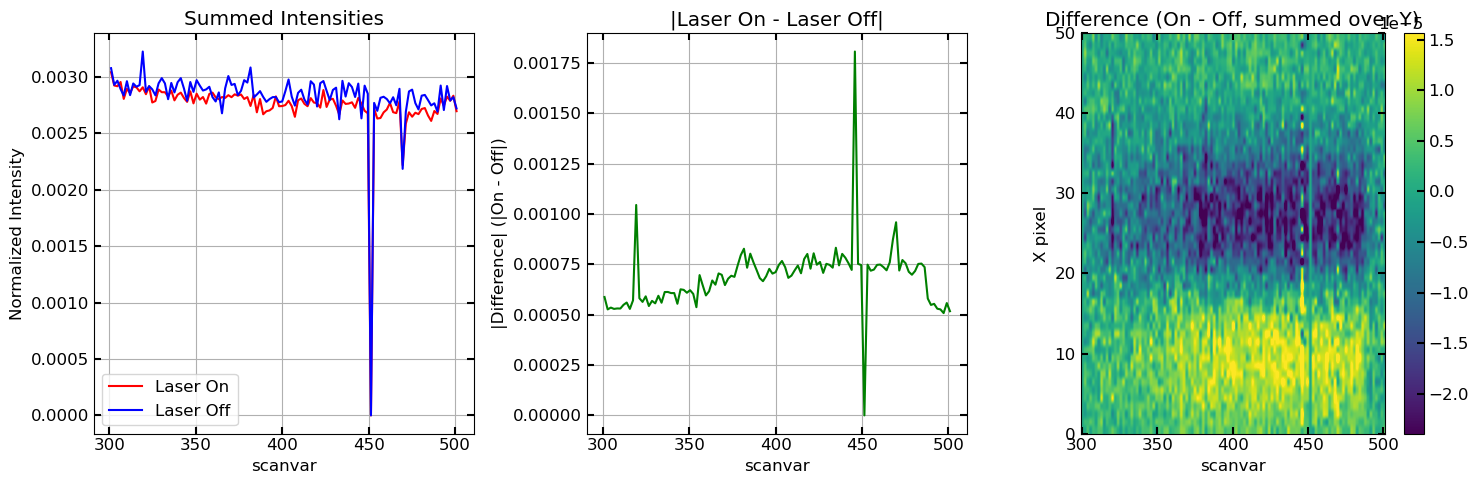

Laser On summed range: nan to nan
Laser Off summed range: nan to nan
Absolute difference range: nan to nan


In [1]:
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization
import XSpect.XSpect_PostProcessing
import XSpect.XSpect_Diagnostics
import numpy as np
import matplotlib.pyplot as plt

xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(lcls_run=24, hutch='mfx', experiment_id='mfx100894224')
xes = XSpect.XSpect_Controller.ScanAnalysis_1D_XES()
keys = ['MfxDg2BmMon/totalIntensityJoules','scan/lasmot8','epix100/ROI_area'] 
names = ['ipm','scan','epix']
xes.key_epix = []
xes.rois = [[400,450]]
xes.friendly_name_epix = ['epix']
xes.set_key_aliases(keys, names)
xes.add_filter('xray','ipm',1.0E2)
xes.add_filter('simultaneous','ipm',1.0E2)
xes.run_parser(['114'])  # 7.5 uJ -0.5 to 2 ps
xes.primary_analysis_loop(xes_experiment)

for f in xes.analyzed_runs:
    laser_on = f.epix_simultaneous_laser_scanvar_reduced[:,400:450,:]
    laser_off = f.epix_xray_not_laser_scanvar_reduced[:,400:450,:]
    norm_on = f.ipm_simultaneous_laser_scanvar_reduced
    norm_off = f.ipm_xray_not_laser_scanvar_reduced
    
    # Normalize first
    normed_laser_on_full = laser_on / norm_on[:, np.newaxis, np.newaxis]
    normed_laser_off_full = laser_off / norm_off[:, np.newaxis, np.newaxis]
    
    # Apply absolute value if >1D array, then sum for 1D plots
    if laser_on.ndim > 1:
        # Calculate difference first, then take absolute value before dimensional reduction
        diff_full = normed_laser_on_full - normed_laser_off_full
        diff_abs = np.abs(diff_full)
        
        # Sum to 1D for line plots
        normed_laser_on = normed_laser_on_full.reshape(normed_laser_on_full.shape[0], -1).sum(axis=1)
        normed_laser_off = normed_laser_off_full.reshape(normed_laser_off_full.shape[0], -1).sum(axis=1)
        diff_abs_summed = diff_abs.reshape(diff_abs.shape[0], -1).sum(axis=1)
    else:
        # For 1D arrays, just use directly
        normed_laser_on = normed_laser_on_full
        normed_laser_off = normed_laser_off_full
        diff_abs_summed = np.abs(normed_laser_on - normed_laser_off)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot 1: Summed intensities vs scan variable
    axes[0].plot(f.scanvar_bins, normed_laser_on, label='Laser On', color='red')
    axes[0].plot(f.scanvar_bins, normed_laser_off, label='Laser Off', color='blue')
    axes[0].set_xlabel('scanvar')
    axes[0].set_ylabel('Normalized Intensity')
    axes[0].set_title('Summed Intensities')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot 2: Absolute Difference
    axes[1].plot(f.scanvar_bins, diff_abs_summed, color='green')
    axes[1].set_xlabel('scanvar')
    axes[1].set_ylabel('|Difference| (|On - Off|)')
    axes[1].set_title('|Laser On - Laser Off|')
    axes[1].grid(True)
    
    # Check if we have image data (3D arrays)
    if laser_on.ndim == 3:
        print(f"Image data detected: shape {laser_on.shape}")
        
        # For image plot, use the original normalized data (without abs)
        # Sum over y-axis to get (shot_bins, x)
        ons_summed_y = np.nansum(normed_laser_on_full, axis=2)
        offs_summed_y = np.nansum(normed_laser_off_full, axis=2)
        diff_image = ons_summed_y - offs_summed_y
        
        # Get intelligent vmin/vmax for difference image
        vmin, vmax = np.percentile(diff_image[~np.isnan(diff_image)], [2, 98])
        
        # Plot 3: Difference image (summed over y)
        im = axes[2].imshow(diff_image.T, 
                           aspect='auto',
                           origin='lower',
                           vmin=vmin, 
                           vmax=vmax,
                           extent=[f.scanvar_bins.min(), f.scanvar_bins.max(), 
                                  0, diff_image.shape[1]])
        axes[2].set_xlabel('scanvar')
        axes[2].set_ylabel('X pixel')
        axes[2].set_title('Difference (On - Off, summed over Y)')
        plt.colorbar(im, ax=axes[2])
        
    else:
        print(f"1D data detected: shape {laser_on.shape}")
        # Hide the image plot if we don't have image data
        axes[2].text(0.5, 0.5, 'No image data\n(not 3D array)', 
                    ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_xticks([])
        axes[2].set_yticks([])
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"Laser On summed range: {normed_laser_on.min():.3e} to {normed_laser_on.max():.3e}")
    print(f"Laser Off summed range: {normed_laser_off.min():.3e} to {normed_laser_off.max():.3e}")
    print(f"Absolute difference range: {diff_abs_summed.min():.3e} to {diff_abs_summed.max():.3e}")